In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Atoms
from ase.io import read

# ML
from kernels import (build_kernel, linear_kernel, gaussian_kernel,
                     linear_kernel_diag, gaussian_kernel_diag,
                     linear_kernel_tri, gaussian_kernel_tri,
                     diag_indices, tri_indices)

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Plotting
import matplotlib.pyplot as plt

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# TODO: generalize for different kernels
# TODO: put kernel metadata in histogram header

In [3]:
# Data type for loading FPS indices
dt = np.dtype({'names': ['idxs', 'distances'], 'formats': ['i8', 'f8']})

In [4]:
# Histogram bin setup
bin_min = -4
bin_max = 1
n_bins = 101
bin_edges = np.logspace(bin_min, bin_max, n_bins)
dx = np.diff(bin_edges)

In [5]:
# Output file header for histograms
header = 'bin_edges bin_widths probability_density'

In [6]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

# DEEM-DEEM

In [16]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)

    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file, dtype=dt)
    idxs = deem_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=True)
    deem_soaps = deem_soaps[idxs, :]
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Initialize histogram bins
    H = np.zeros(n_bins-1)
    DAB_min = np.zeros(len(deem_soaps))
    
    # Distance histogram diagonals
    KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)
    KAA = KBB
    
    # Iteratively build KAB and the distance histogram
    for sdx, soap in enumerate(tqdm(deem_soaps)):
        
        # Compute one row of the kernel
        soap = np.reshape(soap, (1, -1)) # Add extra dimension for cdist in gaussian_kernel
        DAB = -2.0*gaussian_kernel(soap, deem_soaps, gamma=gamma)
        DAB = np.reshape(DAB, (-1)) # Remove extra dimension
        
        # Compute squared distance for that row
        DAB += KAA[sdx] + KBB
        
        # Compute minimum distance for the row, excluding self
        # (np.delete does not modify in-place)
        DAB_min[sdx] = np.sqrt(np.amin(np.delete(DAB, sdx)))
        
        # Compute distance, taking only distances above the main diagonal
        # to avoid zero self-distances and double-counting
        DAB = np.sqrt(DAB[sdx+1:])
                
        # Compute histogram
        h, _ = np.histogram(DAB, bins=bin_edges, density=False)
        
        # Increment histogram
        H += h
     
    # Normalize the histogram
    H /= dx*np.sum(H)
    
    # Compute histogram of minimum distances
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)
    
    # Save
    np.savetxt(f'{work_dir}/DEEM_10k-DEEM_10k_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM_10k-DEEM_10k_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)

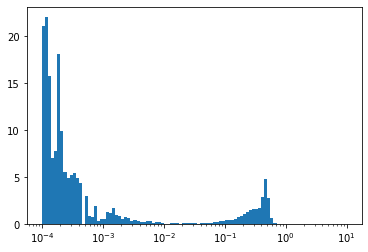

In [17]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

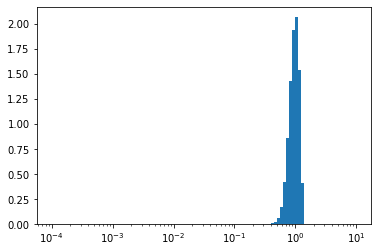

In [18]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# IZA-IZA

In [7]:
# Load IZA cantons
iza_cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', 
                         dtype={'names': ['structures', 'cantons'], 'formats': ['U3', 'i8']})
canton_labels = np.unique(iza_cantons['cantons'])
print(canton_labels)

[1 2 3 4]


In [8]:
# Load IZA Si atom counts
n_Si_iza = np.loadtxt('../Processed_Data/IZA_226/n_Si.dat', dtype=int)

In [9]:
# Load IZA structures to check that cantons are connected to the correct structure
iza = read('../Raw_Data/GULP/IZA_226/IZA.xyz', index=':')
ids = [i.info['Filename'][4:7] for i in iza]
print(all(ids == iza_cantons['structures']))

True


In [10]:
for cutoff in cutoffs:
    
    # Set data files   
    idxs_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)

    iza_unique = np.loadtxt(idxs_file_iza, dtype=dt)
    idxs_iza = iza_unique['idxs']
    
    # Load unique SOAPs
    iza_soaps = load_structures_from_hdf5(soaps_file_iza, datasets=None, concatenate=True)
    iza_soaps = iza_soaps[idxs_iza, :]
    
    # Associate each environment with a structure index
    split_idxs = np.cumsum(n_Si_iza)
    cantons = np.zeros(iza_soaps.shape[0], dtype=int)
    for idx, i in enumerate(idxs_iza):
        struct_number = np.nonzero((split_idxs-i) > 0)[0][0]
        cantons[idx] = iza_cantons[struct_number]['cantons']
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Compute kernel diagonals
    DAB = gaussian_kernel(iza_soaps, iza_soaps, gamma=gamma)
    KBB = np.diag(DAB)
    KAA = KBB.reshape((-1, 1))

    # Compute kernel between datasets
    DAB = -2.0*DAB

    # Compute squared kernel distance
    DAB += KAA + KBB
    
    # Loop over cantons
    for cdx, canton_A in enumerate(canton_labels):
        
        # Get IZA environments in the specified canton
        canton_idxs_A = np.nonzero(cantons == canton_A)[0]
        DAB_canton_A = DAB[canton_idxs_A, :]

        # Loop over cantons
        for canton_B in canton_labels[cdx:]:
        
            # Get IZA environments in the specified secondary canton
            canton_idxs_B = np.nonzero(cantons == canton_B)[0]
            DAB_canton_AB = DAB_canton_A[:, canton_idxs_B]

            # Self-distances
            if canton_A == canton_B:
                
                # Flatten to remove diagonal
                DAB_canton_min_AB = DAB_canton_AB.flatten()
                
                # Remove diagonal entries
                diag_idxs = np.arange(0, DAB_canton_AB.size, DAB_canton_AB.shape[0] + 1)
                DAB_canton_min_AB = np.sqrt(np.delete(DAB_canton_min_AB, diag_idxs))
                
                # Reshape into matrix
                DAB_canton_min_AB = np.reshape(DAB_canton_min_AB, 
                                               (DAB_canton_AB.shape[0], DAB_canton_AB.shape[0] - 1))
                
                # Compute minimum distance for each environment in each dataset
                DAB_canton_min_AB = np.amin(DAB_canton_min_AB, axis=1)
                
                # Upper triangular indices
                triu_idxs = np.triu_indices(DAB_canton_AB.shape[0], k=1)

                # Compute kernel distance
                DAB_canton_AB = np.sqrt(DAB_canton_AB[triu_idxs])
                
                # Compute distance histograms
                h, _ = np.histogram(DAB_canton_AB, bins=bin_edges, density=True)
                h_min, _ = np.histogram(DAB_canton_min_AB, bins=bin_edges, density=True)
                
                # Save histograms
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_histogram.dat',
                           np.column_stack((bin_edges[0:-1], dx, h)), header=header)
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_min_histogram.dat', 
                           np.column_stack((bin_edges[0:-1], dx, h_min)), header=header)
                
            else:
                
                # Compute kernel distance
                DAB_canton_AB = np.sqrt(DAB_canton_AB)

                # Compute minimum distance for each environment in each dataset
                # min_AB = distance from an A to the nearest B for every A
                # min_BA = distance from a B to the nearest A for every B
                DAB_canton_min_AB = np.amin(DAB_canton_AB, axis=1)
                DAB_canton_min_BA = np.amin(DAB_canton_AB, axis=0)
                
                # Compute distance histograms
                h, _ = np.histogram(DAB_canton_AB, bins=bin_edges, density=True)
                h_min_AB, _ = np.histogram(DAB_canton_min_AB, bins=bin_edges, density=True)
                h_min_BA, _ = np.histogram(DAB_canton_min_BA, bins=bin_edges, density=True)
                
                # Save histograms
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_histogram.dat',
                           np.column_stack((bin_edges[0:-1], dx, h)), header=header)
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_min_histogram.dat', 
                           np.column_stack((bin_edges[0:-1], dx, h_min_AB)), header=header)
                np.savetxt(f'{work_dir}/IZA_226_{canton_B}-IZA_226_{canton_A}_min_histogram.dat', 
                           np.column_stack((bin_edges[0:-1], dx, h_min_BA)), header=header)
    
    # Compute histograms on whole IZA database
    # Flatten to remove diagonal            
    DAB_min = DAB.flatten()
    
    # Remove diagonal entries
    diag_idxs = np.arange(0, DAB.size, DAB.shape[0] + 1)
    DAB_min = np.sqrt(np.delete(DAB_min, diag_idxs))
    
    # Reshape into matrix
    DAB_min = np.reshape(DAB_min, (DAB.shape[0], DAB.shape[0] - 1))
    
    # Compute minimum distance for each environment
    DAB_min = np.amin(DAB_min, axis=1)
    
    # Triangular indices
    triu_idxs = np.triu_indices(iza_soaps.shape[0], k=1)
    
    # Compute kernel distance
    DAB = np.sqrt(DAB[triu_idxs])

    # Compute distance histograms
    H, _ = np.histogram(DAB, bins=bin_edges, density=True)
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)

    # Save histograms
    np.savetxt(f'{work_dir}/IZA_226-IZA_226_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/IZA_226-IZA_226_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


**NOTE:** We will probably get an error in the above cell with the 4th canton (RWY), as the minimum distances might all be smaller than the cutoff, and therefore the histogram will return all NaNs

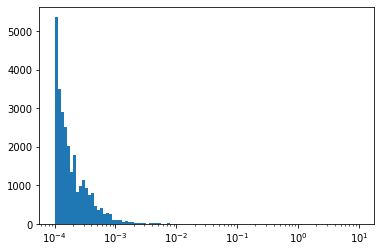

In [11]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

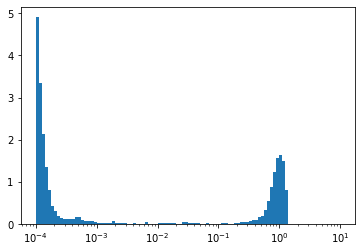

In [12]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# COD-COD

In [13]:
for cutoff in cutoffs:
    
    # Set data files        
    idxs_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
     
    # Load indices of unique environments
    cod_unique = np.loadtxt(idxs_file_cod, dtype=dt)
    idxs_cod = cod_unique['idxs']
    
    # Load unique SOAPs
    cod_soaps = load_structures_from_hdf5(soaps_file_cod, datasets=None, concatenate=True)
    cod_soaps = cod_soaps[idxs_cod, :]
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Compute kernel diagonals
    DAB = gaussian_kernel(cod_soaps, cod_soaps, gamma=gamma)
    KBB = np.diag(DAB)
    KAA = KBB.reshape((-1, 1))

    # Compute kernel between datasets
    DAB = -2.0*DAB

    # Compute squared kernel distance
    DAB += KAA + KBB
    
    # Compute minimum distance for each environment in each dataset
    # Flatten to remove diagonal
    DAB_min = DAB.flatten()
    
    # Remove diagonal entries
    diag_idxs = np.arange(0, DAB.size, DAB.shape[0] + 1)
    DAB_min = np.sqrt(np.delete(DAB_min, diag_idxs))
    
    # Reshape into matrix
    DAB_min = np.reshape(DAB_min, (DAB.shape[0], DAB.shape[0] - 1))
    DAB_min = np.amin(DAB_min, axis=1)
    
    # Triangular indices
    triu_idxs = np.triu_indices(cod_soaps.shape[0], k=1)
    
    # Compute kernel distance
    DAB = np.sqrt(DAB[triu_idxs])

    # Compute distance histograms
    H, _ = np.histogram(DAB, bins=bin_edges, density=True)
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)

    # Save histograms
    np.savetxt(f'{work_dir}/COD_196-COD_196_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/COD_196-COD_196_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)

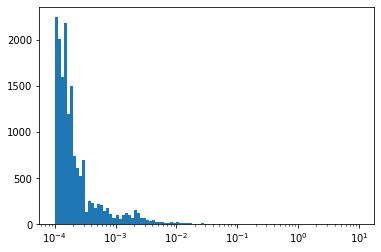

In [14]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

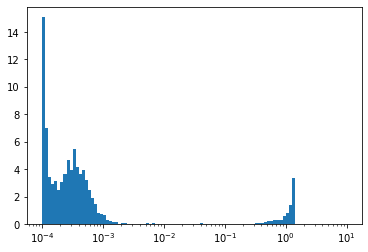

In [15]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# IZA-DEEM

In [19]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        
    idxs_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
     
    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file_deem, dtype=dt)
    idxs_deem = deem_unique['idxs']
    
    iza_unique = np.loadtxt(idxs_file_iza, dtype=dt)
    idxs_iza = iza_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file_deem, datasets=None, concatenate=True)
    deem_soaps = deem_soaps[idxs_deem, :]
    
    iza_soaps = load_structures_from_hdf5(soaps_file_iza, datasets=None, concatenate=True)
    iza_soaps = iza_soaps[idxs_iza, :]
    
    # Associate each environment with a structure index
    split_idxs = np.cumsum(n_Si_iza)
    cantons = np.zeros(iza_soaps.shape[0], dtype=int)
    for idx, i in enumerate(idxs_iza):
        struct_number = np.nonzero((split_idxs-i) > 0)[0][0]
        cantons[idx] = iza_cantons[struct_number]['cantons']
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Initialize histogram bins
    H = np.zeros(n_bins-1)
    H_min_AB = np.zeros(n_bins-1)
    H_min_BA = np.zeros(n_bins-1)
    
    # Loop over cantons
    for canton in tqdm(canton_labels):
        
        # Get IZA environments in the specified canton
        canton_idxs = np.nonzero(cantons == canton)[0]
        
        # Compute kernel diagonals for each dataset
        # A = IZA
        # B = DEEM
        KAA = gaussian_kernel_diag(iza_soaps[canton_idxs], iza_soaps[canton_idxs], gamma=gamma, k=0)
        KAA = np.reshape(KAA, (-1, 1))
        KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)

        # Compute kernel between datasets
        DAB = -2.0*gaussian_kernel(iza_soaps[canton_idxs], deem_soaps, gamma=gamma)

        # Compute kernel distance
        DAB += KAA + KBB 
        DAB = np.sqrt(DAB)

        # Compute minimum distance for each environment in each dataset
        # min_AB = distance from an A to the nearest B for every A
        # min_BA = distance from a B to the nearest A for every B
        DAB_min_AB = np.amin(DAB, axis=1)
        DAB_min_BA = np.amin(DAB, axis=0)

        # Compute cantonal distance histograms
        h, _ = np.histogram(DAB, bins=bin_edges, density=False)
        h_min_AB, _ = np.histogram(DAB_min_AB, bins=bin_edges, density=False)
        h_min_BA, _ = np.histogram(DAB_min_BA, bins=bin_edges, density=False)
                
        # Increment total histograms
        H += h
        H_min_AB += h_min_AB
        H_min_BA += h_min_BA
        
        # Normalize cantonal histograms 
        # (do without "/=" b/c need to promote to float)
        h = h / (dx*np.sum(h))
        h_min_AB = h_min_AB / (dx*np.sum(h_min_AB))
        h_min_BA = h_min_BA / (dx*np.sum(h_min_BA))
        
        # Save cantonal histograms
        np.savetxt(f'{work_dir}/IZA_226_{canton}-DEEM_10k_histogram.dat', 
                   np.column_stack((bin_edges[0:-1], dx, h)),
                   header=header)
        np.savetxt(f'{work_dir}/IZA_226_{canton}-DEEM_10k_min_histogram.dat', 
                   np.column_stack((bin_edges[0:-1], dx, h_min_AB)),
                   header=header)
        np.savetxt(f'{work_dir}/DEEM_10k-IZA_226_{canton}_min_histogram.dat',
                   np.column_stack((bin_edges[0:-1], dx, h_min_BA)),
                   header=header)
        
    # Normalize the total histograms
    H /= dx*np.sum(H)
    H_min_AB /= dx*np.sum(H_min_AB)
    H_min_BA /= dx*np.sum(H_min_BA)
    
    # Save histograms
    np.savetxt(f'{work_dir}/IZA_226-DEEM_10k_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/IZA_226-DEEM_10k_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM_10k-IZA_226_min_histogram.dat',
               np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
               header=header)

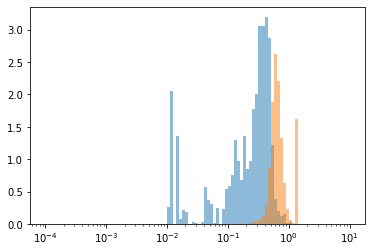

In [20]:
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

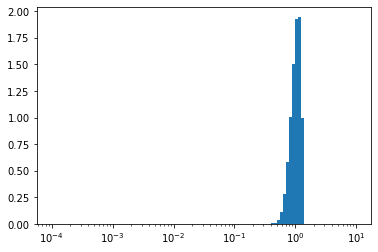

In [21]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# COD-DEEM

In [22]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        
    idxs_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
     
    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file_deem, dtype=dt)
    idxs_deem = deem_unique['idxs']
    
    cod_unique = np.loadtxt(idxs_file_cod, dtype=dt)
    idxs_cod = cod_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file_deem, datasets=None, concatenate=True)
    deem_soaps = deem_soaps[idxs_deem, :]
    
    cod_soaps = load_structures_from_hdf5(soaps_file_cod, datasets=None, concatenate=True)
    cod_soaps = cod_soaps[idxs_cod, :]
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Compute kernel diagonals for each dataset
    # A = COD
    # B = DEEM
    KAA = gaussian_kernel_diag(cod_soaps, cod_soaps, gamma=gamma, k=0)
    KAA = np.reshape(KAA, (-1, 1))
    KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)

    # Compute kernel between datasets
    DAB = -2.0*gaussian_kernel(cod_soaps, deem_soaps, gamma=gamma)

    # Compute kernel distance
    DAB += KAA + KBB 
    DAB = np.sqrt(DAB)

    # Compute minimum distance for each environment in each dataset
    # min_AB = distance from an A to the nearest B for every A
    # min_BA = distance from a B to the nearest A for every B
    DAB_min_AB = np.amin(DAB, axis=1)
    DAB_min_BA = np.amin(DAB, axis=0)

    # Compute distance histograms
    H, _ = np.histogram(DAB, bins=bin_edges, density=True)
    H_min_AB, _ = np.histogram(DAB_min_AB, bins=bin_edges, density=True)
    H_min_BA, _ = np.histogram(DAB_min_BA, bins=bin_edges, density=True)

    # Save histograms
    np.savetxt(f'{work_dir}/COD_196-DEEM_10k_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/COD_196-DEEM_10k_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM_10k-COD_196_min_histogram.dat',
               np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
               header=header)

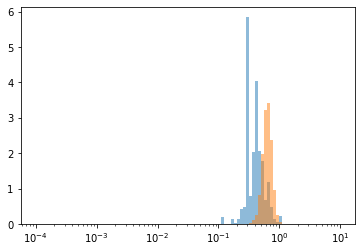

In [23]:
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

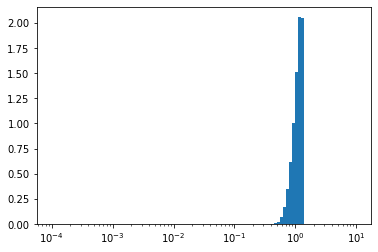

In [24]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()